# Demo example: Applying Quality Control.

In this example we apply Quality Control (QC) on the demo data. 
## Create your dataset
We start by creating a dataset.

In [1]:
import metobs_toolkit
your_dataset = metobs_toolkit.Dataset()
your_dataset.update_settings(
    input_data_file=metobs_toolkit.demo_datafile, # path to the data file
    input_metadata_file=metobs_toolkit.demo_metadatafile,
    template_file=metobs_toolkit.demo_template,
)

your_dataset.import_data_from_file()

A number of quality control methods are available in the toolkit. We can classify them into two groups:
1. **Quality control for missing/duplicated or invalid timestamps**. This is applied to the raw data and is not based on the observational value but merely on the presence of a record. 
2. **Quality control for bad observations**. These are not automatically executed. These checks are performed in a sequence of specific checks, that are looking for signatures of typically bad observations.

## Quality control for missing/duplicated and invalid timestamps
Since this is applied to the raw data, the following quality control checks are automatically performed when reading the data:
* Nan check: Test if the value of an observation can be converted to a numeric value.
* Missing check: Test if there are missing records. These missing records are labeled as *missing observation* or as *gap* (if there are consecutive missing records).
* Duplicate check: Test if each observation (station name, timestamp, observation type) is unique.

As an example you can see that there is a missing timestamp in the time series of some stations:

<Axes: title={'center': 'Temperatuur of vlinder02'}, xlabel='datetime', ylabel='temp (Celsius)'>

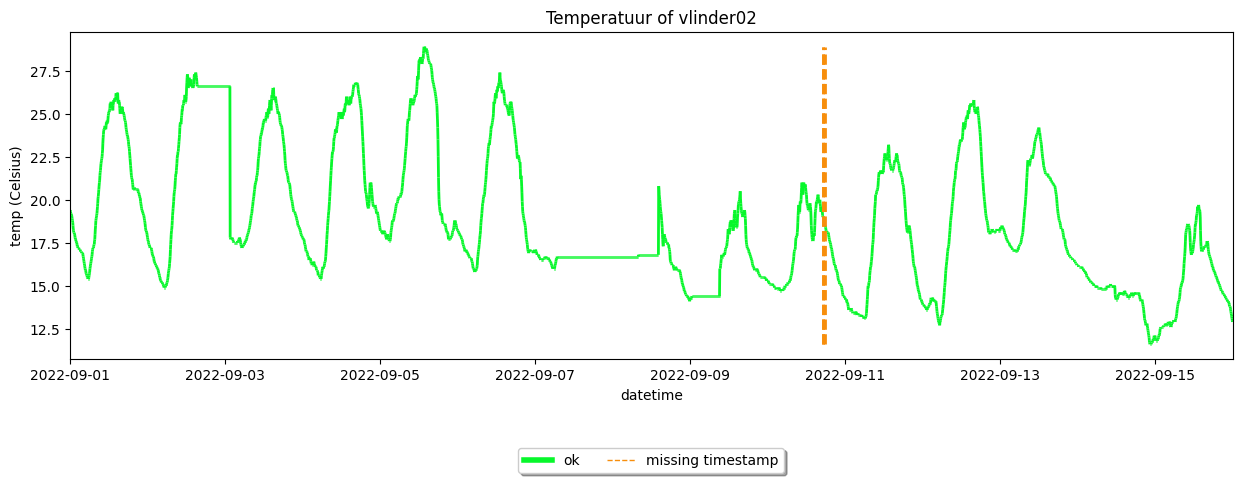

In [2]:
your_dataset.get_station('vlinder02').make_plot(colorby='label')


## Quality control for bad observations
The following checks are available:
* [Gross value check](https://vergauwenthomas.github.io/MetObs_toolkit/_autosummary/metobs_toolkit.qc_checks.gross_value_check.html#metobs_toolkit.qc_checks.gross_value_check): A threshold check that observations should be between the thresholds
* [Persistence check](https://vergauwenthomas.github.io/MetObs_toolkit/_autosummary/metobs_toolkit.qc_checks.persistance_check.html#metobs_toolkit.qc_checks.persistance_check): Test observations to change over a specific period.
* [Repetitions check](https://vergauwenthomas.github.io/MetObs_toolkit/_autosummary/metobs_toolkit.qc_checks.repetitions_check.html#metobs_toolkit.qc_checks.repetitions_check): Test if an observation changes after several records.
* [Spike check](https://vergauwenthomas.github.io/MetObs_toolkit/_autosummary/metobs_toolkit.qc_checks.step_check.html#metobs_toolkit.qc_checks.step_check): Test if observations do not produce spikes in time series.
* [Window variation check](https://vergauwenthomas.github.io/MetObs_toolkit/_autosummary/metobs_toolkit.qc_checks.window_variation_check.html#metobs_toolkit.qc_checks.window_variation_check): Test if the variation exceeds the threshold in moving time windows.
* [Toolkit Buddy check](https://vergauwenthomas.github.io/MetObs_toolkit/_autosummary/metobs_toolkit.qc_checks.toolkit_buddy_check.html#metobs_toolkit.qc_checks.toolkit_buddy_check): Spatial buddy check.
* [TITAN Buddy check](https://vergauwenthomas.github.io/MetObs_toolkit/_autosummary/metobs_toolkit.qc_checks.titan_buddy_check.html#metobs_toolkit.qc_checks.titan_buddy_check): The [Titanlib version of the buddy check](https://github.com/metno/titanlib/wiki/Buddy-check).
* [TITAN Spatial consistency test](https://vergauwenthomas.github.io/MetObs_toolkit/_autosummary/metobs_toolkit.qc_checks.titan_sct_resistant_check.html#metobs_toolkit.qc_checks.titan_sct_resistant_check): Apply the Titanlib (robust) [Spatial-Consistency-Test](https://github.com/metno/titanlib/wiki/Spatial-consistency-test-resistant) (SCT).

Each check requires a set of specific settings, often stored per specific observation type. A set of default settings, for temperature observations, are stored in the settings of each dataset. Use the *show()* method, and scroll to the QC section to see all QC settings.


In [3]:
your_dataset.settings.show()

All settings:
 
 ---------------------------------------

 ---------------- IO (settings) ----------------------

* output_folder: 

  -None 

* input_data_file: 

  -/home/thoverga/Documents/VLINDER_github/MetObs_toolkit/metobs_toolkit/datafiles/demo_datafile.csv 

* input_metadata_file: 

  -/home/thoverga/Documents/VLINDER_github/MetObs_toolkit/metobs_toolkit/datafiles/demo_metadatafile.csv 

 ---------------- time_settings (settings) ----------------------

* target_time_res: 

  -60T 

* resample_method: 

  -nearest 

* resample_limit: 

  -1 

* timezone: 

  -UTC 

* freq_estimation_method: 

  -highest 

* freq_estimation_simplify: 

  -True 

* freq_estimation_simplify_error: 

  -2T 

 ---------------- app (settings) ----------------------

* print_fmt_datetime: 

  -%d/%m/%Y %H:%M:%S 

* print_max_n: 

  -40 

* plot_settings: 

  - time_series: 

    -{'figsize': (15, 5), 'colormap': 'tab20', 'linewidth': 2, 'linestyle_ok': '-', 'linestyle_fill': '--', 'linezorder': 1, 'sc

Use the [update_qc_settings()](https://vergauwenthomas.github.io/MetObs_toolkit/_autosummary/metobs_toolkit.dataset_settings_updater.Dataset.html#metobs_toolkit.dataset_settings_updater.Dataset.update_qc_settings) method to update the default settings.

In [4]:
your_dataset.update_qc_settings(obstype='temp',
                                gross_value_max_value=26.3,
                                persis_time_win_to_check='30T' #30 minutes
                                )

To apply the quality control on the full dataset use the [apply_quality_control()](https://vergauwenthomas.github.io/MetObs_toolkit/_autosummary/metobs_toolkit.dataset.Dataset.html#metobs_toolkit.dataset.Dataset.apply_quality_control) method. Spatial quality control checks can be applied by using the [apply_buddy_check()](https://vergauwenthomas.github.io/MetObs_toolkit/_autosummary/metobs_toolkit.dataset.Dataset.html#metobs_toolkit.dataset.Dataset.apply_buddy_check), [apply_titan_buddy_check()](https://vergauwenthomas.github.io/MetObs_toolkit/_autosummary/metobs_toolkit.dataset.Dataset.html#metobs_toolkit.dataset.Dataset.apply_titan_buddy_check) and [apply_titan_sct_resistant_check()](https://vergauwenthomas.github.io/MetObs_toolkit/_autosummary/metobs_toolkit.dataset.Dataset.html#metobs_toolkit.dataset.Dataset.apply_titan_sct_resistant_check) methods.

In [5]:
your_dataset.apply_quality_control(
        obstype="temp",  # which observations to check
        gross_value=True,  # apply gross_value check?
        persistance=True,  # apply persistence check?
        step=True,  # apply the step check?
        window_variation=True,  # apply internal consistency check?
    )

Use the dataset.show() or the time series plot methods to see the effect of the quality control.

<Axes: title={'center': 'Temperatuur for all stations. '}, xlabel='datetime', ylabel='temp (Celsius)'>

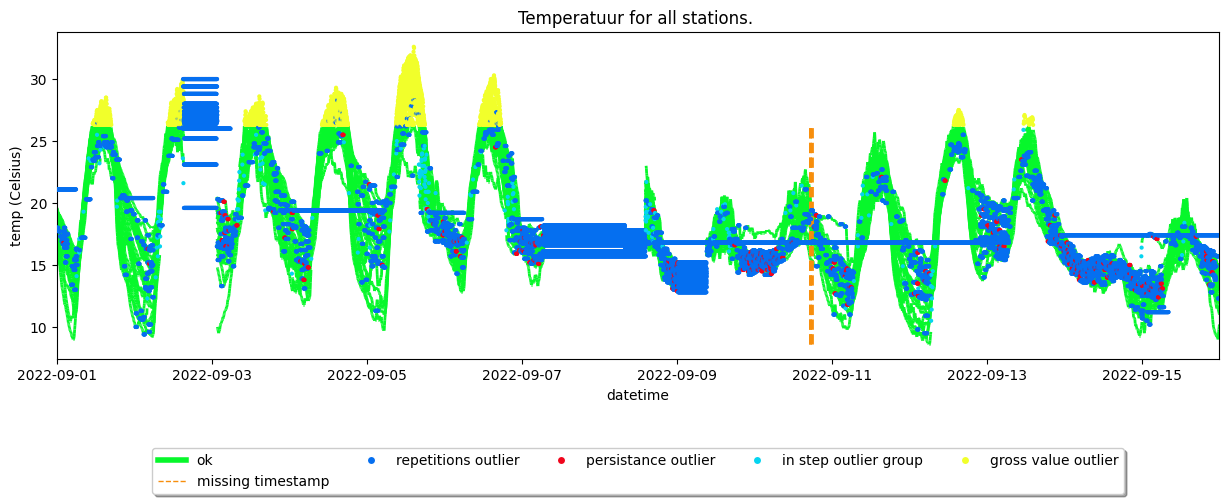

In [6]:
your_dataset.make_plot(obstype='temp', colorby='label')

If you are interested in the performance of the applied QC, you can use the [get_qc_stats()](https://vergauwenthomas.github.io/MetObs_toolkit/_autosummary/metobs_toolkit.dataset.Dataset.html#metobs_toolkit.dataset.Dataset.apply_titan_sct_resistant_check) method to get an overview of the frequency statistics.

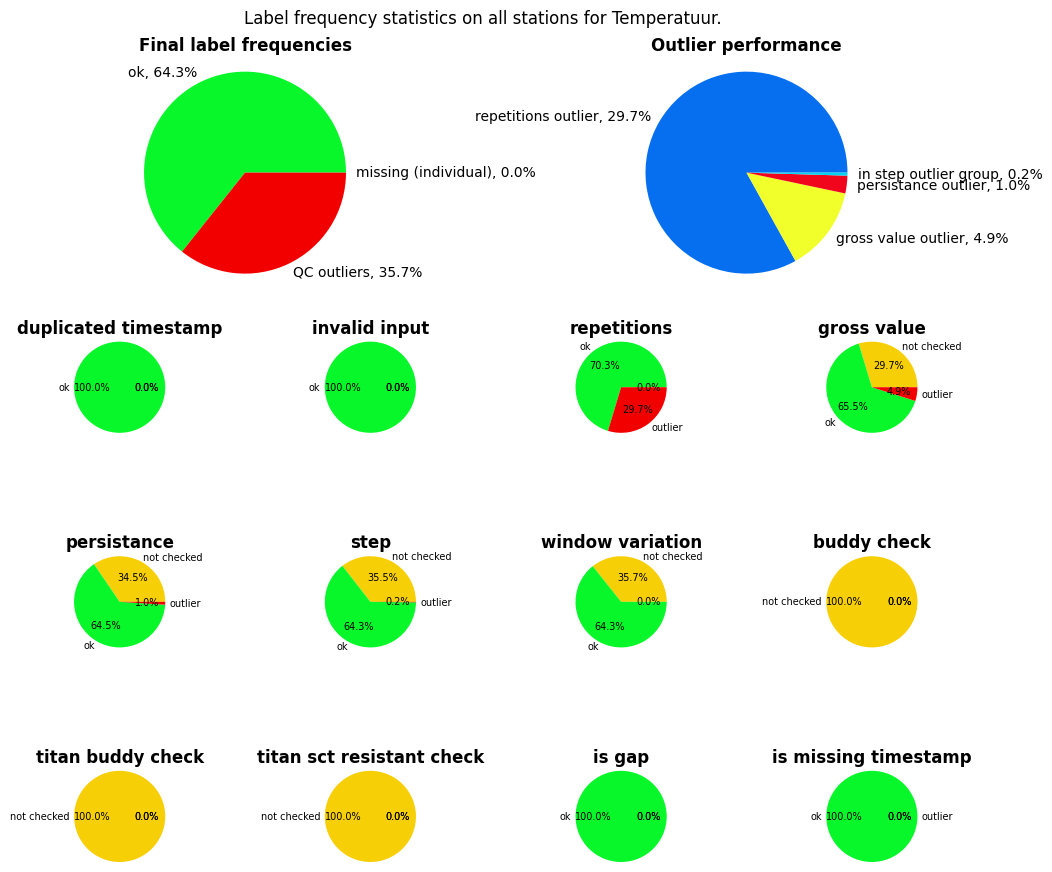

({'ok': 64.28984788359789,
  'QC outliers': 35.707671957671955,
  'missing (gaps)': 0.0,
  'missing (individual)': 0.00248015873015873},
 {'repetitions outlier': 29.658564814814813,
  'gross value outlier': 4.869378306878307,
  'persistance outlier': 1.0085978835978835,
  'in step outlier group': 0.17113095238095238,
  'duplicated timestamp outlier': 0.0,
  'invalid input': 0.0,
  'in window variation outlier group': 0.0,
  'buddy check outlier': 0.0,
  'titan buddy check outlier': 0.0,
  'sct resistant check outlier': 0.0},
 {'duplicated_timestamp': {'not checked': 0.0, 'ok': 100.0, 'outlier': 0.0},
  'invalid_input': {'not checked': 0.0, 'ok': 100.0, 'outlier': 0.0},
  'repetitions': {'not checked': 0.0,
   'ok': 70.34143518518519,
   'outlier': 29.658564814814813},
  'gross_value': {'not checked': 29.658564814814813,
   'ok': 65.47205687830689,
   'outlier': 4.869378306878307},
  'persistance': {'not checked': 34.52794312169312,
   'ok': 64.46345899470899,
   'outlier': 1.0085978835

In [7]:
your_dataset.get_qc_stats(obstype='temp', make_plot=True)

## Quality control exercise
For a more detailed reference you can use this [Quality control exercise](https://github.com/vergauwenthomas/MetObs_toolkit/blob/master/examples/Quality_control_excercise_02.ipynb), which was created in the context of the [COST FAIRNESS](https://www.cost.eu/actions/CA20108/) summer school 2023 in Ghent.